In [30]:
# coding=utf-8
from scapy.all import *
import binascii
import socket, struct
import time

import crcmod
import libnum

from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether

import numpy as np

plc_cube = []
hmi_cube = []

seq = []

def ip2long(ip):
    """
    Convert an IP string to long
    """
    packedIP = socket.inet_aton(ip)
    return struct.unpack("!L", packedIP)[0]

def packet_analysis(pkt):
    if TCP in pkt and IP in pkt:
        if(pkt[TCP].dport == 502):
            hmi_cube.append(float(str(pkt.time)))

In [31]:
try:
    start_t = time.time()
    #sniff(offline='DataSet/captures1_v2/captures1_v2/modbusQuery2Flooding/eth2dump-modbusQuery2Flooding1m-0,5h_1.pcap', prn=packet_analysis, store=0, filter="dst host 172.27.224.250")
    sniff(offline='DataSet/captures1_v2/captures1_v2/mitm/eth2dump-mitm-change-1m-0,5h_1.pcap', prn=packet_analysis, store=0, filter="dst 172.27.224.250")
    #sniff(offline='DataSet/Dex2019_0002_attack3.pcap', prn=packet_analysis, store=0, count=100000, filter="src host 192.168.1.10 and dst host 192.168.1.20")    
    print('Completed')
    stop_t  = time.time()
    delta_time = stop_t - start_t
    print(delta_time)

except Exception as sniff_dec_err:
    traceback.print_exc()
    print(str(sniff_dec_err))

Completed
5.013831377029419


In [32]:
hmi_cube = np.asarray(hmi_cube)
print(hmi_cube.shape)
attack_hmi = hmi_cube

(22079,)


In [33]:
print("attack HMI",attack_hmi.shape)
print(max(attack_hmi))
print(min(attack_hmi))
print(max(attack_hmi)-min(attack_hmi))

attack HMI (22079,)
1535060653.881127
1535058855.166155
1798.7149720191956


In [34]:
attack_hmi_diff = np.diff(attack_hmi)
print(max(attack_hmi_diff))
print(min(attack_hmi_diff))

1.4390308856964111
9.5367431640625e-07


1.0000000000000036
[0.26160527 0.00188507 0.00183872 0.02867208 0.00121759 0.0012624
 0.00124701 0.00104151 0.00162915 0.00131481 0.00102856 0.00072553
 0.00093975 0.00095737 0.00106362 0.00168673 0.00167032 0.0008836
 0.00085088 0.00104484 0.00106545 0.00171275 0.00169719 0.00140741
 0.00133194 0.00102204 0.00116772 0.00235822 0.00127387 0.00212859
 0.00624213 0.0018608  0.00272088 0.00189101 0.13541829 0.00121193
 0.00119359 0.00117661 0.0010095  0.0244438  0.00085098 0.0010613
 0.00059594 0.00133693 0.00064186 0.00068683 0.00083602 0.00086305
 0.00037267 0.00045938 0.0004155  0.00081672 0.00042832 0.00089518
 0.00065475]
[0.23545539 0.00160064 0.00170264 0.00678523 0.00104508 0.00087332
 0.00112276 0.00084521 0.000912   0.00120401 0.00101795 0.00072524
 0.00092342 0.00089854 0.00092069 0.00087171 0.00151894 0.00082317
 0.00078492 0.00094847 0.00086511 0.00085135 0.001691   0.00128746
 0.0007853  0.00074574 0.00097638 0.001296   0.00126801 0.00126727
 0.00181741 0.00110897 0.00146077

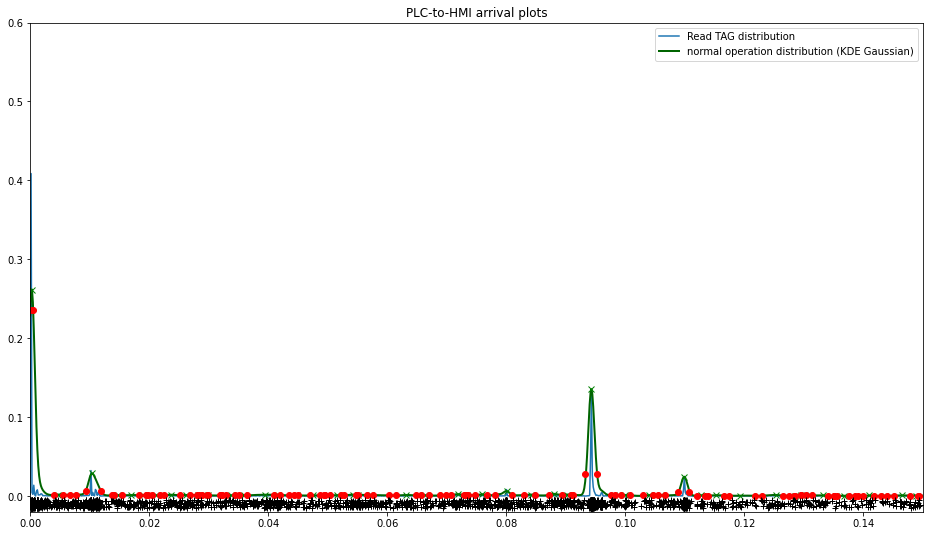

In [35]:
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema
from scipy.signal import find_peaks, chirp, find_peaks, peak_widths

maxrange = 0.15
N = 1000
np.random.seed(1)

hmi_diff = attack_hmi_diff


X = hmi_diff[:9000].reshape(-1,1)
X_plot = np.linspace(-0.0, maxrange, N)[:, np.newaxis]
hist, bin_edges = np.histogram(hmi_diff[:9000], bins=N, range=(0.0,maxrange), density=True)
bin_edges = bin_edges[:-1]
true_dens = hist[:]*maxrange*(1/N)
print(np.sum(true_dens))

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(X_plot[:, 0], true_dens,label='Read TAG distribution')

kde = KernelDensity(kernel='gaussian', bandwidth=0.0005).fit(X)
log_dens = kde.score_samples(X_plot)
#print(kde.get_params())
dens = np.exp(log_dens)/1000

peaks, _ = find_peaks(dens)

valleys = peak_widths(dens, peaks, rel_height=0.8)

print(dens[peaks])
print(valleys[1])
print(valleys)
print("Xplot_peak",X_plot[peaks])
ax.plot(X_plot[:, 0], dens, color='darkgreen', lw=2,
        linestyle='-', label='normal operation distribution (KDE Gaussian)')
ax.plot(X_plot[peaks],dens[peaks], "gx")
#ax.plot(X_plot[valleys],dens[valleys], "go")
ax.plot(valleys[2]*maxrange*(1/N),valleys[1], "ro")
ax.plot(valleys[3]*maxrange*(1/N),valleys[1], "ro")

#stack position and values
nppeaks = np.hstack((X_plot[peaks],dens[peaks].reshape(-1,1)))
npbounds = np.stack((valleys[2]*maxrange*(1/N),valleys[3]*maxrange*(1/N),valleys[1]), axis=-1)
print("normal peaks",nppeaks)
print("normal bounds",npbounds)
np.save("np_peaks_CRITIS.npy",nppeaks)
np.save("np_bounds_CRITIS.npy",npbounds)

ax.title.set_text("PLC-to-HMI arrival plots")
ax.legend(loc='upper right')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-0.0, maxrange)
ax.set_ylim(-0.02, 0.6)

s = X_plot[:, 0]
e = np.exp(log_dens)/1000
a = X
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

<ipython-input-36-192b1db3a01e>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,5))
/home/xalanaseon/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

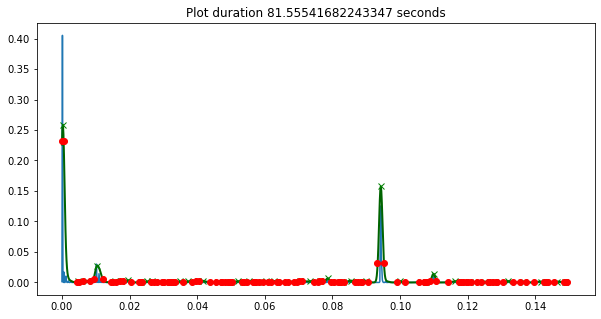

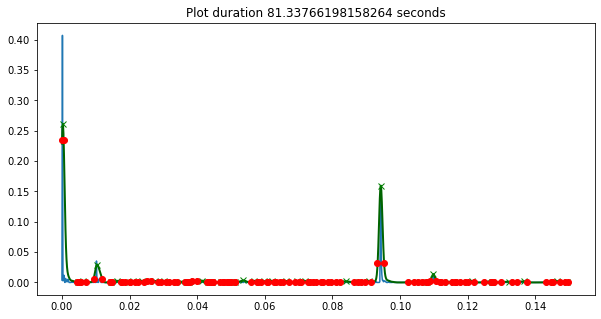

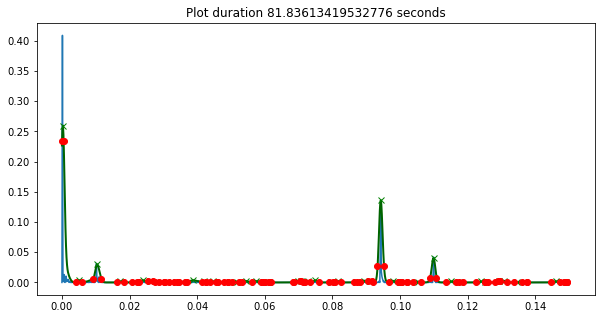

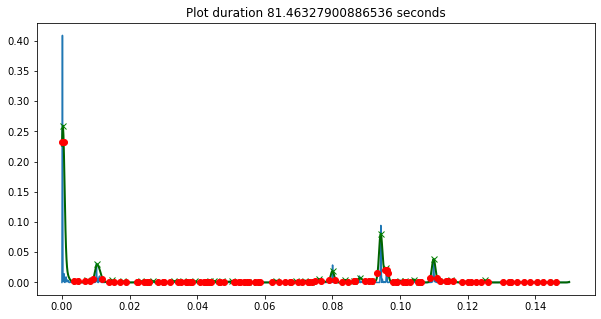

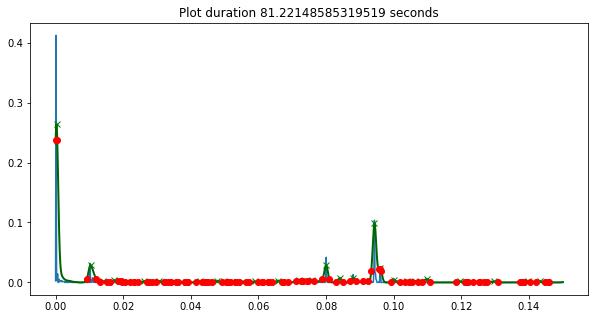

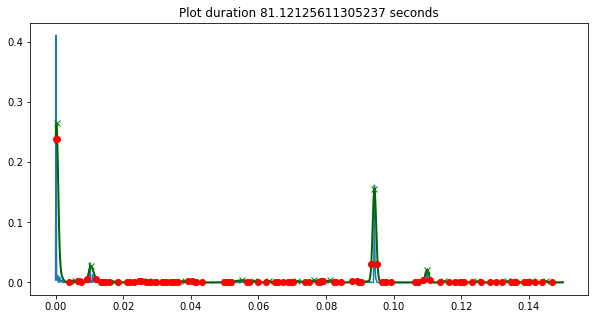

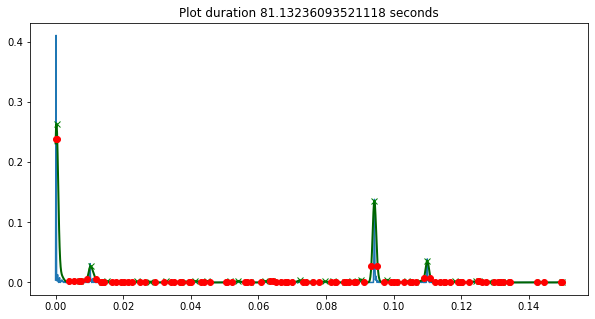

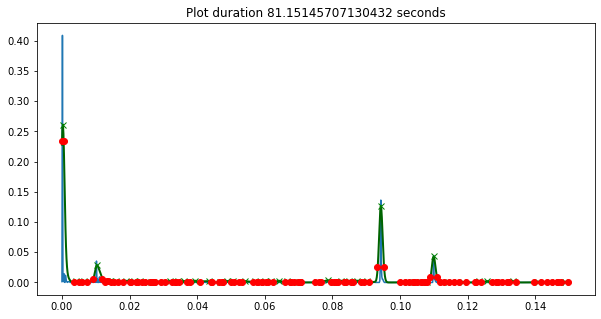

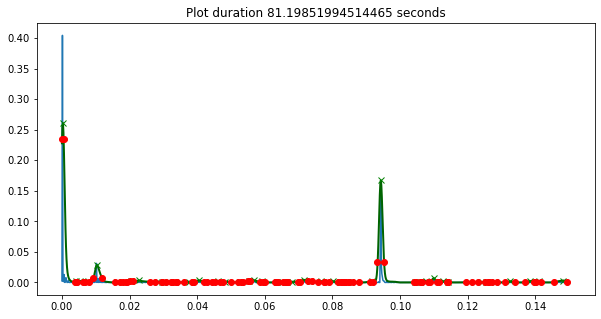

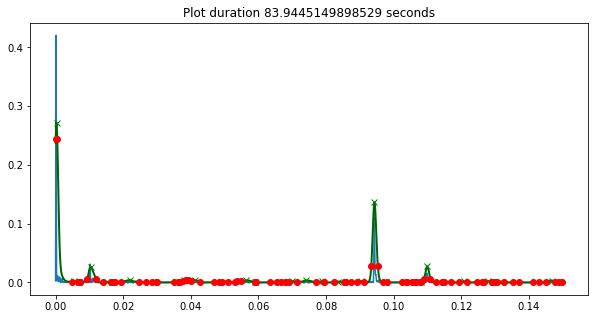

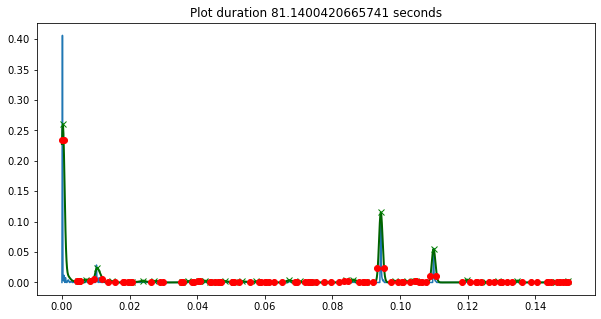

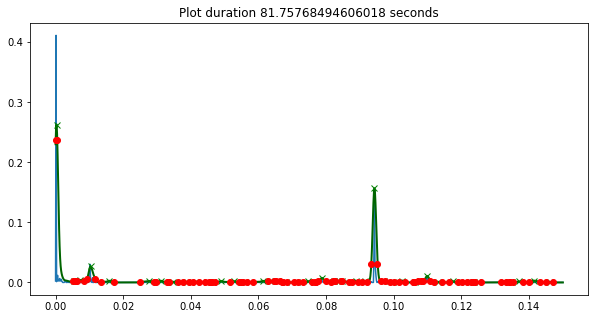

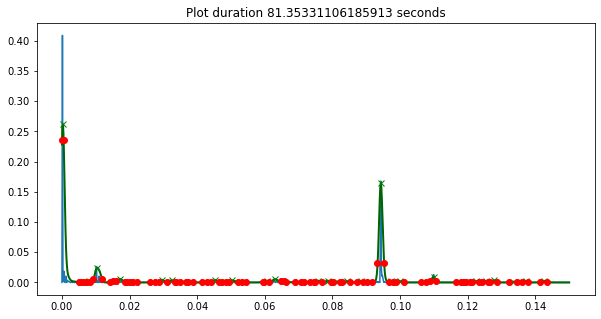

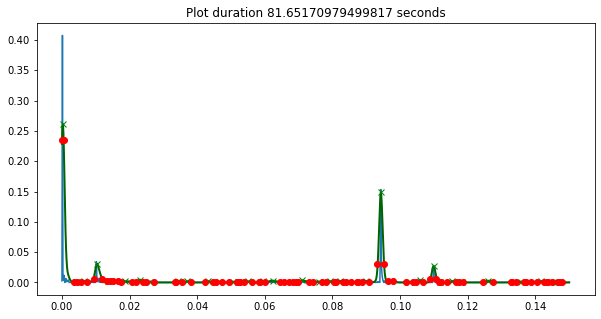

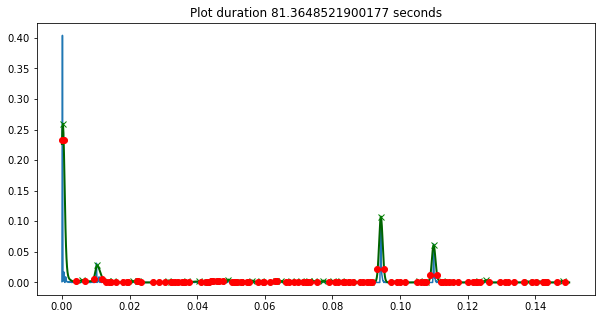

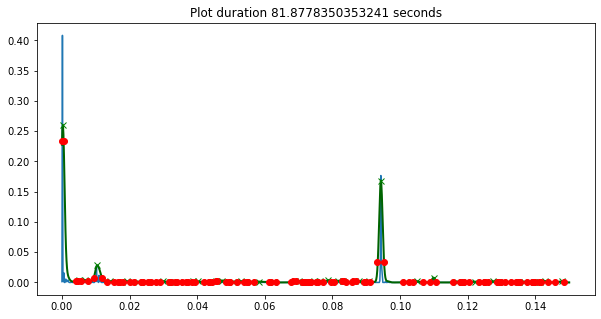

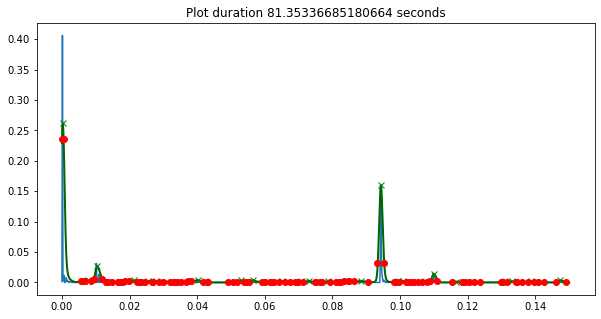

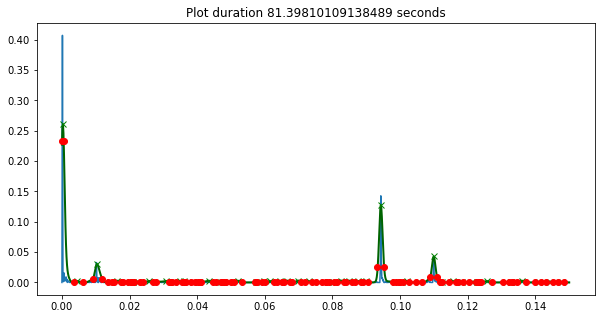

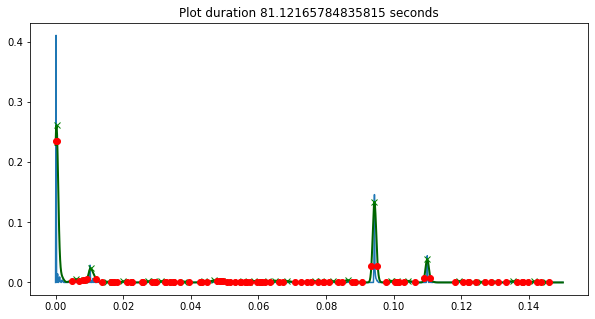

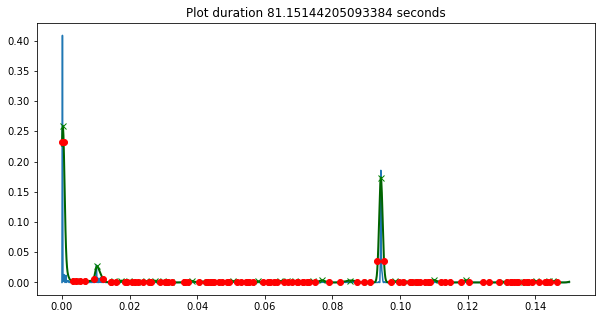

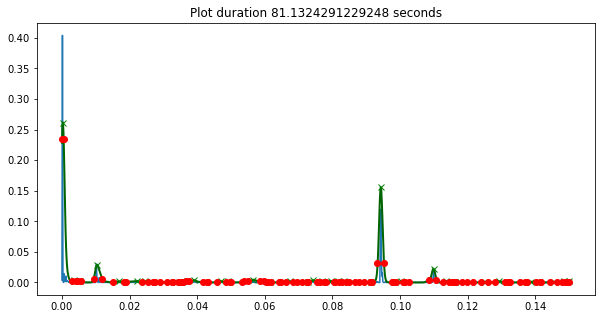

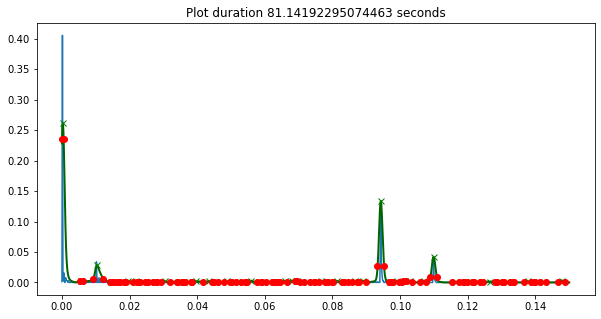

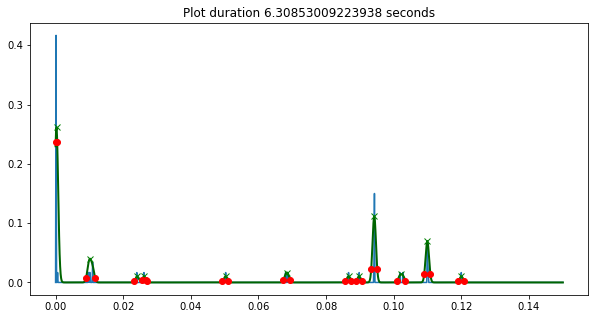

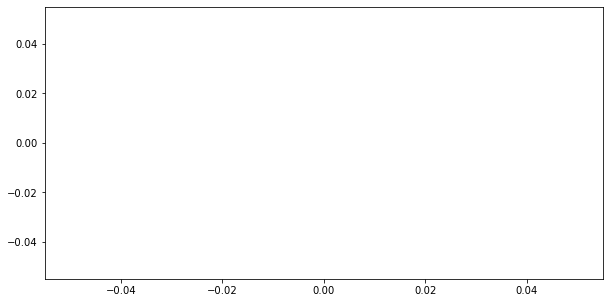

In [36]:
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema
from scipy.signal import find_peaks, chirp, find_peaks, peak_widths

maxrange = 0.15
N = 1000
np.random.seed(1)


# Plot a 1D density example
for k in range(40):
    fold = k*N
    hmi_diff = attack_hmi_diff[fold:fold+N]
    
    X = hmi_diff.reshape(-1,1)
    X_plot = np.linspace(-0.0, maxrange, N)[:, np.newaxis]
    hist, bin_edges = np.histogram(hmi_diff, bins=N, range=(0.0,maxrange), density=True)
    bin_edges = bin_edges[:-1]
    true_dens = hist[:]*maxrange*(1/N)
    #print(np.sum(true_dens))

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(X_plot[:, 0], true_dens,label='Read TAG distribution')

    kde = KernelDensity(kernel='gaussian', bandwidth=0.0005).fit(X)
    log_dens = kde.score_samples(X_plot)
    #print(kde.get_params())
    dens = np.exp(log_dens)/1000

    peaks, _ = find_peaks(dens)

    valleys = peak_widths(dens, peaks, rel_height=0.8)

    #print(dens[peaks])
    #print(valleys[1])
    #print(valleys)
    #print("Xplot_peak",X_plot[peaks])
    ax.title.set_text("Plot duration " + str(np.sum(hmi_diff)) + " seconds")
    ax.plot(X_plot[:, 0], dens, color='darkgreen', lw=2,
            linestyle='-', label='normal operation distribution (KDE Gaussian)')
    ax.plot(X_plot[peaks],dens[peaks], "gx")
    #ax.plot(X_plot[valleys],dens[valleys], "go")
    ax.plot(valleys[2]*maxrange*(1/N),valleys[1], "ro")
    ax.plot(valleys[3]*maxrange*(1/N),valleys[1], "ro")